In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
# from vae.arch import VAE
from vae.arch_vaegan2 import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time
from model import make_model

import config


np.set_printoptions(precision=4, suppress = True)

In [39]:
def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma

def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np.random.randn(*log_sigma.shape) 
    return z


def get_z_from_rnn_output(y_pred):
    HIDDEN_UNITS = 256
    GAUSSIAN_MIXTURES = 5
    Z_DIM = 32
    d = GAUSSIAN_MIXTURES * Z_DIM

    z_pred = y_pred[:(3*d)]
    rew_pred = y_pred[-1]

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    chosen_log_pi = np.zeros(Z_DIM)
    chosen_mu = np.zeros(Z_DIM)
    chosen_log_sigma = np.zeros(Z_DIM)

    # adjust temperatures
    logmix2 = np.copy(log_pi)
    logmix2 -= logmix2.max()
    logmix2 = np.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(Z_DIM, 1)


    for j in range(Z_DIM):
        idx = get_pi_idx(np.random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j, idx]
        chosen_log_sigma[j] = log_sigma[j,idx]

    next_z = sample_z(chosen_mu, chosen_log_sigma)

    # print(next_z)
    # print(rew_pred)
    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0
        
    return next_z, next_reward, chosen_mu

In [40]:
model = make_model()
model.make_env('car_racing')

In [41]:
model.load_model('./controller/GAN/car_racing.cma.2.8.best.json')

loading file ./controller/GAN/car_racing.cma.2.8.best.json


In [42]:
z_weight = model.weight[0][:32,2]
h_weight = model.weight[0][32:,2]

In [43]:
z_weight

array([-0.1705,  0.3106, -0.5865,  0.1104, -0.034 , -0.3701, -0.1313,
       -0.7858,  0.5165, -0.2566,  0.1403, -0.1527, -0.0596,  0.1559,
        0.1373, -0.6218, -0.3536, -0.6088,  0.2716,  0.0185,  0.0391,
       -0.0189, -0.076 ,  0.3591, -0.3763, -0.0629,  0.1908, -0.247 ,
        0.0728,  0.3435,  0.3242,  0.3888])

In [44]:
h_weight

array([-0.0118,  0.4593,  0.2376,  0.3925, -0.0081, -0.3423,  0.3404,
       -0.0683, -0.1599, -0.0965,  0.4089,  0.3891, -0.1644, -0.168 ,
       -0.2493,  0.3307,  0.3353, -0.0201,  0.1125,  0.4033,  0.1835,
        0.3492,  0.0353, -0.4045, -0.4378, -0.7443,  0.3513, -0.2168,
       -0.0169,  0.0197, -0.0783, -0.4732,  0.1419,  0.9266,  0.2158,
        0.0784, -0.4342,  0.3828, -0.5322, -0.0415,  0.6467, -0.0544,
        0.3392,  0.3225, -0.6718, -0.049 , -0.4358, -0.1438, -0.4347,
        0.8427, -0.3223, -0.4079,  0.4364, -0.1139, -0.3047, -0.2678,
       -0.2943,  0.2397,  0.0614,  0.1556, -0.4489, -0.3647,  1.0279,
       -0.0304,  0.6686, -0.0442,  0.0029, -0.0616,  0.1423, -1.0101,
       -1.0414,  0.1473,  0.1171, -0.1333, -0.7359, -0.2138, -0.0166,
        0.3792, -0.0333, -0.3408, -0.2543,  0.1872, -0.3818, -0.0753,
        0.4761,  0.1357, -0.1883,  0.5873,  0.4334, -0.3932,  0.071 ,
        0.0557, -0.1147, -0.0686,  0.0299,  0.4632, -0.5755,  0.4023,
       -0.2159,  0.2

In [45]:
rollout_files = np.load('./data/rollout/1040613.npz') 
obs_file = rollout_files['obs']
action_file = rollout_files['action']
reward_file = rollout_files['reward']
done_file = rollout_files['done']

series_files = np.load('./data/GAN_series/1040613.npz') 
mu_file = series_files['mu']
log_var_file = series_files['log_var']
action_2_file = series_files['action']
reward_2_file = series_files['reward']
done_2_file = series_files['done']


In [46]:
obs = obs_file[4]
action = [0,0,0]
reward = 0
model.reset()

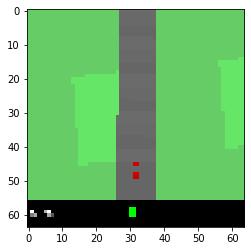

In [47]:
plt.imshow(obs)

In [48]:
vae_encoded_obs = model.update(obs, 0)

In [49]:
vae_encoded_obs

array([ 0.0315,  1.8299,  0.5313, -0.102 , -0.6582,  1.4235,  0.57  ,
       -0.7741, -0.6186, -0.2607,  0.8481,  1.3961, -0.3316, -0.5468,
        0.515 , -0.82  ,  0.6824, -0.3759,  1.9645,  0.6725,  0.3263,
       -0.1072, -1.7227, -0.527 ,  2.4948,  1.0245, -0.2635,  1.5472,
        1.7665, -0.4924, -0.2426, -0.3907], dtype=float32)

In [50]:
recon = model.vae.decoder.predict(np.array([vae_encoded_obs]))[0]

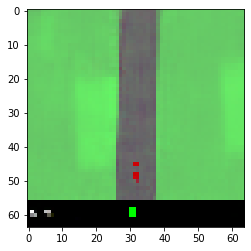

In [51]:
plt.imshow(recon)

In [52]:
# obs = obs_file[0]
action = [0,1,0]
reward = 0
model.reset()
total_reward = 0
total_pseudo_reward = 0
t = 0

obs = model.env.reset()

model.env.render('rgb_array')

actions0 = []
actions1 = []
actions2 = []

In [53]:
# while(1):
from PIL import Image, ImageDraw
imagelist = []

for i in range(400):
    ######

    obs = config.adjust_obs(obs)
    reward = config.adjust_reward(reward)
    
    total_pseudo_reward+= reward

    vae_encoded_obs = model.update(obs, 0)

    recon = model.vae.decoder.predict(np.array([vae_encoded_obs]))[0]
    
#     input_to_rnn = [np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]),np.zeros(shape=(1,256)),np.zeros(shape=(1,256))]
#     input_to_rnn = [np.array([[np.concatenate([np.zeros(32), action, [reward]])]]),np.array([model.hidden]),np.array([model.cell_values])]


    input_to_rnn = [np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]),np.array([model.hidden]),np.array([model.cell_values])]

    #     print(np.array([[np.concatenate([vae_encoded_obs, action, [reward]])]]).shape)
    #     print(np.array([model.hidden]).shape)
    #     print(np.array([model.cell_values]).shape)

    out = model.rnn.forward.predict(input_to_rnn)

    y_pred = out[0][0][0]
    h = out[1][0]
    c = out[2][0]

    model.hidden = h
    model.cell_values = c

    next_z, next_reward, chosen_mu = get_z_from_rnn_output(y_pred)

    recon_next_z = model.vae.decoder.predict(np.array([next_z]))[0]

    controller_obs = np.concatenate([vae_encoded_obs,model.hidden])
    action = model.get_action(controller_obs, t=0, add_noise=0)
    #     actions0.append(action[0])
    #     actions1.append(action[1])
    #     actions2.append(action[2])

    #     action = model.activations(action)
#     action = [1,1,0]
    obs, reward, done, _ = model.env.step(action)
    
    total_reward+= reward
    img = Image.fromarray(obs)
    imagelist.append(img)

#     plt.gca().cla() 
#     plt.imshow( obs)

#     display.clear_output(wait=True)
#     display.display(plt.gcf()) 
    
#     print(total_reward)
#     print(total_pseudo_reward)
#     print(t)
#     print(action)
    if i % 50 == 0:
        print(i)
    t += 1
imagelist[0].save('GAN_out.gif', save_all=True, append_images=imagelist[1:])

    #     print(action)

0
50
100
150
200
250
300
350
